## IMPUTED SQL - PYTHON PIPELINE

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from datetime import date
import datetime
import time
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_percentage_error
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.mplot3d import Axes3D
import warnings
warnings.filterwarnings('ignore')

In [2]:
server = 'DESKTOP-9ASSRIE\SQLEXPRESS'
database = 'PAI_CA1_IMPUTED'
packages = ['sqlalchemy', 'pyodbc']
engine = create_engine('mssql+pyodbc://{}/{}?driver=SQL Server'.format(server, database))

In [3]:
%%time

## establish connection to database
connection = engine.connect()

## obtain Sensor Data and store in DataFrames
cursor = connection.execute('SELECT * FROM Sensor')
sensor = pd.DataFrame(data=cursor.fetchall(), columns=cursor.keys())

## obtain Driver Data
cursor = connection.execute('SELECT * FROM Driver')
driver = pd.DataFrame(data=cursor.fetchall(), columns=cursor.keys())

## obtain Safety Data
cursor = connection.execute('SELECT * FROM Safety')
safety = pd.DataFrame(data=cursor.fetchall(), columns=cursor.keys())

## close connection to database
connection.close()

Wall time: 35.6 s


In [4]:
safety

,bookingID,driverID,label
0,0.000000e+00,48.0,0
1,1.000000e+00,74.0,1
2,1.000000e+01,75.0,0
3,1.005022e+12,64.0,1
4,1.005022e+12,49.0,1
...,...,...,...
19995,9.964324e+11,57.0,0
19996,9.964324e+11,27.0,0
19997,9.964324e+11,70.0,0
19998,9.964324e+11,87.0,0


In [5]:
merged_df = pd.merge(sensor, safety, on='bookingID')

In [ ]:
# group by Team, get mean, min, and max value of Age for each value of Team.
grouped_single = df.groupby('Team').agg({'Age': ['mean', 'min', 'max']})

print(grouped_single)
## https://jamesrledoux.com/code/group-by-aggregate-pandas

In [8]:
merged_df = merged_df.groupby('bookingID').mean()

In [9]:
merged_df

,accuracy,bearing,acceleration_x,acceleration_y,acceleration_z,gyro_x,gyro_y,gyro_z,second,speed,driverID,label
bookingID,,,,,,,,,,,,
0.000000e+00,9.876652,176.568456,-0.704909,-9.603081,-1.531921,0.004499,-0.001074,-0.001705,925.852423,9.044214,48.0,0.0
1.000000e+00,3.719780,125.318182,-0.509291,9.537512,-2.203588,-0.000885,-0.004368,0.002048,576.813131,7.530312,74.0,1.0
2.000000e+00,3.794337,184.403614,0.276034,9.769132,0.059092,-0.005663,-0.009084,0.004222,313.578313,2.821090,40.0,1.0
4.000000e+00,10.000000,149.305491,-0.377782,-9.377874,-2.652164,-0.023964,0.024274,0.002985,543.901210,6.056069,112.0,1.0
6.000000e+00,4.607496,194.290875,0.552613,9.515931,2.322779,0.006580,-0.010496,0.001646,538.218631,4.641173,68.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
1.709397e+12,4.082112,169.047210,0.093675,1.914510,9.767778,0.033120,-0.017303,-0.008537,541.008584,2.402633,72.0,1.0
1.709397e+12,11.898256,177.555276,0.561403,-8.703409,-4.460335,-0.011916,0.005619,-0.004322,424.104651,7.544601,101.0,1.0
1.709397e+12,9.366045,197.028329,-0.206549,9.063331,3.340217,0.001207,-0.005927,-0.000665,579.665722,12.681133,39.0,1.0


IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

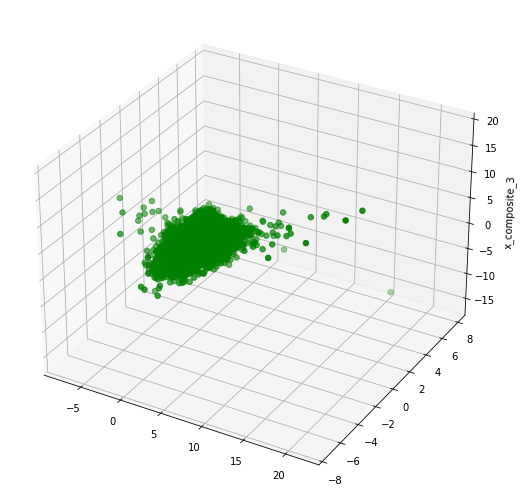

In [12]:
# Outlier Detection
classifier_dict = {"One-Class SVM": OneClassSVM(nu=0.05),
                   "Isolation Forest": IsolationForest(contamination=0.05),
                   "Cluster-based LOF": LocalOutlierFactor(contamination=0.05)}
Outliers = pd.DataFrame()
for i, (clf_name, clf) in enumerate(classifier_dict.items()):
    clf.fit(merged_df)
    merged_df["anomaly"] = clf.fit_predict(merged_df)
    outliers_subset = merged_df[merged_df.anomaly == -1]
    outliers_subset = outliers_subset.assign(model = clf_name)
    Outliers = pd.concat([Outliers, outliers_subset], axis=0, ignore_index=False)

pca = PCA(n_components=3) # reduce to k=3 dimensions
scaler = StandardScaler()
X = scaler.fit_transform(merged_df)
X_reduce = pca.fit_transform(X)
fig = plt.figure(figsize=(11,9))
ax = fig.add_subplot(111, projection="3d")
ax.set_zlabel("x_composite_3")
ax.scatter(X_reduce[:, 0], X_reduce[:, 1], zs=X_reduce[:, 2], s=30, lw=1, label="inliers",c="green")
ax.scatter(X_reduce[Outliers[Outliers['model']=='One-Class SVM'].index, 0],
           X_reduce[Outliers[Outliers['model']=='One-Class SVM'].index, 1],
           X_reduce[Outliers[Outliers['model']=='One-Class SVM'].index, 2],
           lw=4, s=40, c="red", label="One Class SVM")
ax.scatter(X_reduce[Outliers[Outliers['model']=='Isolation Forest'].index, 0],
           X_reduce[Outliers[Outliers['model']=='Isolation Forest'].index, 1],
           X_reduce[Outliers[Outliers['model']=='Isolation Forest'].index, 2],
           lw=4, s=40, marker='x', c="blue", label="Isolation Forest")
ax.scatter(X_reduce[Outliers[Outliers['model']=='Cluster-based LOF'].index, 0],
           X_reduce[Outliers[Outliers['model']=='Cluster-based LOF'].index, 1],
           X_reduce[Outliers[Outliers['model']=='Cluster-based LOF'].index, 2],
           lw=4, s=50, c="orange", label="Cluster-based LOF")
plt.title("Anomaly Detection for Housing Dataset", fontsize=20)
plt.legend()
plt.tight_layout()